# Time Series Forecasting

### How LSTM Works
LSTM is specifically designed to solve the vanishing gradient problem of traditional RNNs. It can capture both short-term dependencies (recent data points) and long-term dependencies (older but still relevant data points) in sequences. This is achieved through its unique architecture, which includes three key components:
- Input Gate: Controls how much of the current input to allow into the memory cell.
- Forget Gate: Decides which information from the past should be forgotten or retained.
- Output Gate: Determines how much of the memory cell to pass on as output.

<img src="images/LSTM.jpg" alt="LSTM" style="width: 600px;"/>

## Extraction

In [10]:
import pandas as pd

In [11]:
df = pd.read_csv('data/conv_chiller.csv')
df

,timestamp,hourly average,usage,hour,day_of_week
0,2024-03-01 00:00:00,5.499743e+07,0.000000,0,4
1,2024-03-01 01:00:00,5.501499e+07,17.561950,1,4
2,2024-03-01 02:00:00,5.502590e+07,10.910917,2,4
3,2024-03-01 03:00:00,5.504377e+07,17.868583,3,4
4,2024-03-01 04:00:00,5.505690e+07,13.137750,4,4
...,...,...,...,...,...
2749,2024-07-17 06:00:00,1.187974e+09,8.686400,6,2
2750,2024-07-17 14:00:00,1.196336e+09,1045.300208,14,2
2751,2024-07-17 15:00:00,1.197282e+09,945.362133,15,2
2752,2024-07-17 16:00:00,1.197532e+09,249.933200,16,2


In [12]:
df['timestamp'] = pd.to_datetime(df['timestamp'])
df.set_index('timestamp', inplace=True)

In [13]:
df.drop(columns=['day_of_week'], inplace=True)

In [14]:
missing_values = df.isnull().sum()
missing_values


hourly average    0
usage             0
hour              0
dtype: int64

Adding more features to see the pattern

In [15]:
df['year'] = df.index.year
df['month'] = df.index.month
df['week'] = df.index.isocalendar().week
df['weekday'] = df.index.weekday 
df['hour'] = df.index.hour

In [16]:
df

,hourly average,usage,hour,year,month,week,weekday
timestamp,,,,,,,
2024-03-01 00:00:00,5.499743e+07,0.000000,0,2024,3,9,4
2024-03-01 01:00:00,5.501499e+07,17.561950,1,2024,3,9,4
2024-03-01 02:00:00,5.502590e+07,10.910917,2,2024,3,9,4
2024-03-01 03:00:00,5.504377e+07,17.868583,3,2024,3,9,4
2024-03-01 04:00:00,5.505690e+07,13.137750,4,2024,3,9,4
...,...,...,...,...,...,...,...
2024-07-17 06:00:00,1.187974e+09,8.686400,6,2024,7,29,2
2024-07-17 14:00:00,1.196336e+09,1045.300208,14,2024,7,29,2
2024-07-17 15:00:00,1.197282e+09,945.362133,15,2024,7,29,2


## EDA

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns

Overall Usage

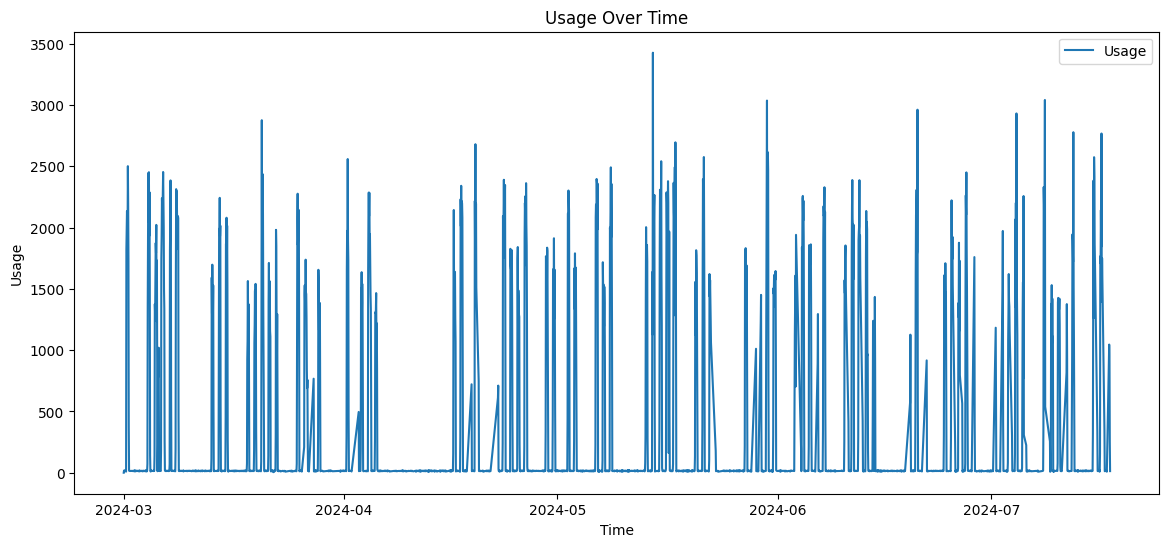

In [18]:
plt.figure(figsize=(14, 6))
plt.plot(df.index, df['usage'], label='Usage')
plt.title('Usage Over Time')
plt.xlabel('Time')
plt.ylabel('Usage')
plt.legend()
plt.show()

Daily Patterns

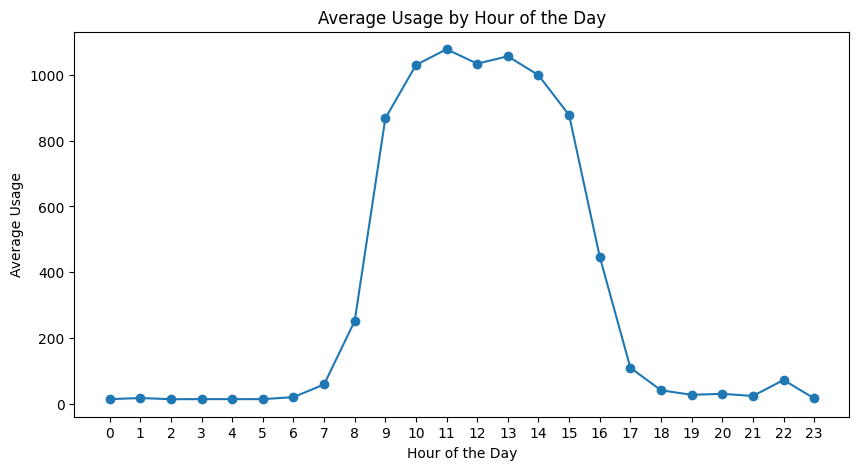

In [19]:
hourly_usage = df.groupby('hour')['usage'].mean()
plt.figure(figsize=(10, 5))
plt.plot(hourly_usage, marker='o')
plt.title('Average Usage by Hour of the Day')
plt.xlabel('Hour of the Day')
plt.ylabel('Average Usage')
plt.xticks(range(0, 24))
plt.show()

Weekly Pattern

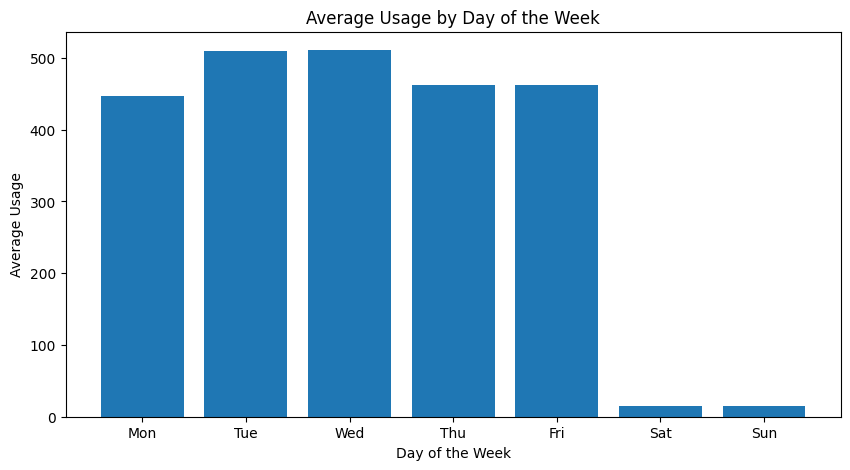

In [20]:
weekday_usage = df.groupby('weekday')['usage'].mean()
plt.figure(figsize=(10, 5))
plt.bar(['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'], weekday_usage)
plt.title('Average Usage by Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Average Usage')
plt.show()

Monthly Pattern

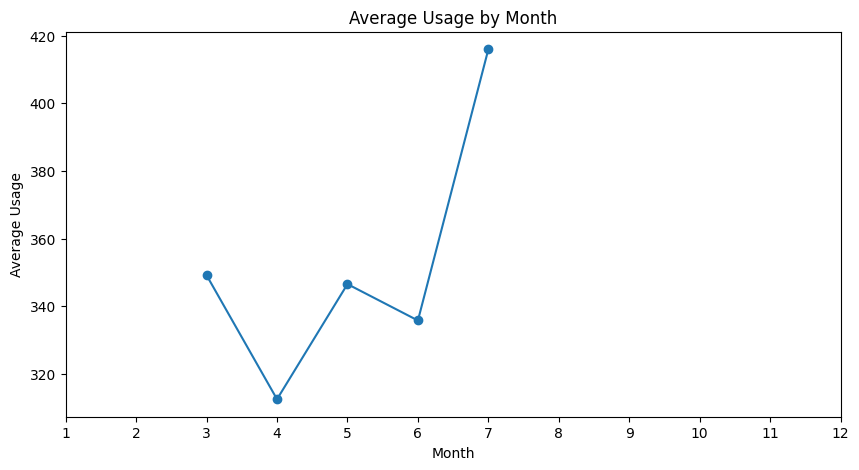

In [21]:
monthly_usage = df.groupby('month')['usage'].mean()
plt.figure(figsize=(10, 5))
plt.plot(monthly_usage, marker='o')
plt.title('Average Usage by Month')
plt.xlabel('Month')
plt.ylabel('Average Usage')
plt.xticks(range(1, 13))
plt.show()

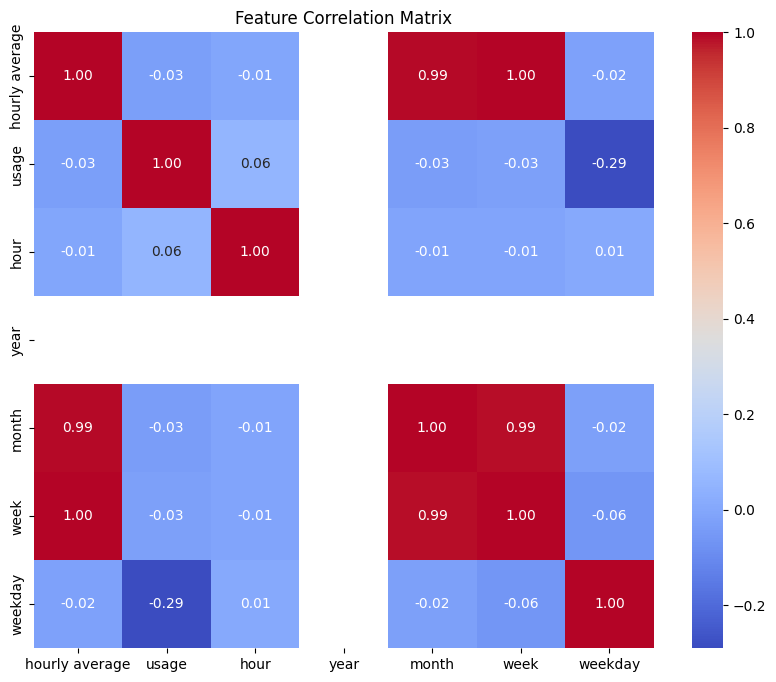

In [13]:
correlation_matrix = df.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Feature Correlation Matrix')
plt.show()

Stationarity check

In [14]:
from statsmodels.tsa.stattools import adfuller

In [15]:
adf_test = adfuller(df['usage'])
adf_statistic = adf_test[0]
p_value = adf_test[1]

adf_statistic, p_value

(-9.713554084220005, 9.967368002682916e-17)

Since the p-value is significantly less than 0.05, we can reject the null hypothesis and conclude that the data is stationary. Thus, the data is suitable for modeling

## Modelling (LSTM)

In [16]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import tensorflow as tf
from keras import metrics
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import MeanAbsoluteError

In [17]:
sequence_length = 24 

scaler = MinMaxScaler(feature_range=(0, 1))
df['usage_scaled'] = scaler.fit_transform(df[['usage']])

def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)


In [18]:
X, y = create_sequences(df['usage_scaled'].values, sequence_length)

train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

In [19]:
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((3562, 24, 1), (3562,), (891, 24, 1), (891,))

In [20]:
model = tf.keras.Sequential([
    tf.keras.Input(shape=(24, 1)),
    tf.keras.layers.LSTM(128, activation='relu', return_sequences=True),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.LSTM(128, activation='relu', return_sequences=False),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1, activation='relu')
])

model.compile(optimizer='adam',
              loss=MeanSquaredError(),
              metrics=[MeanAbsoluteError()])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 24, 128)        │        66,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 24, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 128)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 198,273 (774.50 KB)

 Trainable params: 198,273 (774.50 KB)

 Non-trainable params: 0 (0.00 B)

In [21]:
X_train.shape

(3562, 24, 1)

In [22]:
history = model.fit(
    X_train, y_train,
    epochs=50, 
    batch_size=32, 
    validation_data=(X_test, y_test),
    verbose=1
)

Epoch 1/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - loss: 0.0354 - mean_absolute_error: 0.1415 - val_loss: 0.0111 - val_mean_absolute_error: 0.0626
Epoch 2/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 0.0147 - mean_absolute_error: 0.0752 - val_loss: 0.0108 - val_mean_absolute_error: 0.0782
Epoch 3/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 0.0123 - mean_absolute_error: 0.0704 - val_loss: 0.0084 - val_mean_absolute_error: 0.0464
Epoch 4/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - loss: 0.0120 - mean_absolute_error: 0.0666 - val_loss: 0.0080 - val_mean_absolute_error: 0.0375
Epoch 5/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 0.0113 - mean_absolute_error: 0.0620 - val_loss: 0.0077 - val_mean_absolute_error: 0.0581
Epoch 6/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 0.0101 - mean_absolute_error: 0.0589 - val_loss: 0.0071 - val_mean_absolute_error: 0.0355
Epoch 7/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 0.0092 - mean_absolute_error: 0.0

## Evaluate

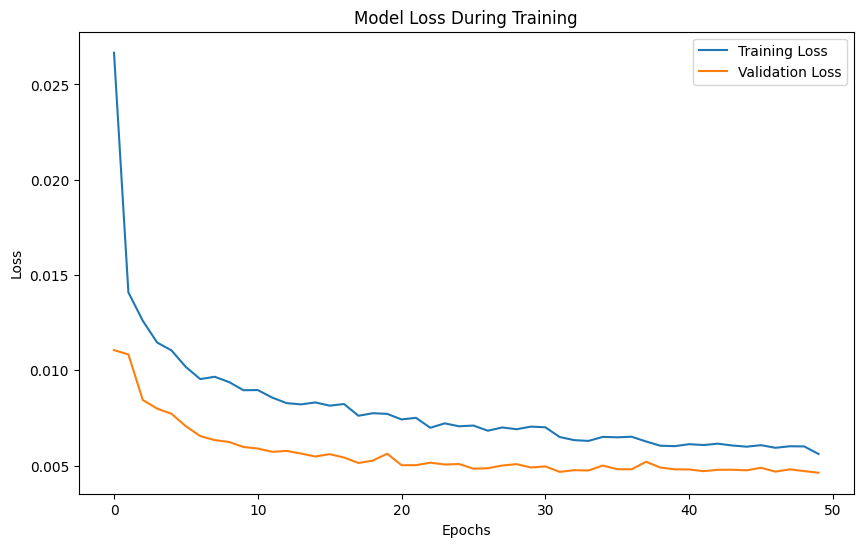

In [23]:
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss During Training')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [26]:
predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions)
y_test = scaler.inverse_transform(y_test.reshape(-1, 1))

28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step


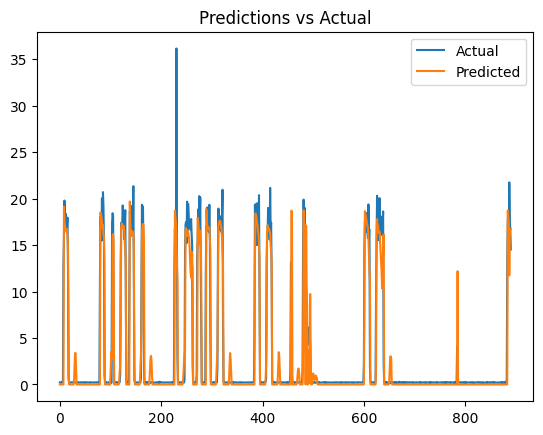

In [27]:
plt.plot(y_test, label='Actual')
plt.plot(predictions, label='Predicted')
plt.legend()
plt.title('Predictions vs Actual')
plt.show()

In [28]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

In [29]:
mse = mean_squared_error(y_test, predictions)
mae = mean_absolute_error(y_test, predictions)
rmse = math.sqrt(mse)

print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")

Mean Squared Error (MSE): 6.0428
Mean Absolute Error (MAE): 1.0313
Root Mean Squared Error (RMSE): 2.4582


In [30]:
start_date = '2024-03-20 00:00:00'  
end_date = '2024-03-25 23:59:59'    

week_indices = (df.index >= start_date) & (df.index <= end_date)
week_data = df[week_indices]

X_week, y_week = create_sequences(week_data['usage_scaled'].values, sequence_length)
X_week = X_week.reshape((X_week.shape[0], X_week.shape[1], 1))

predictions_week = model.predict(X_week)
predictions_week = scaler.inverse_transform(predictions_week)
y_week = scaler.inverse_transform(y_week.reshape(-1, 1))

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


In [31]:
import matplotlib.dates as mdates

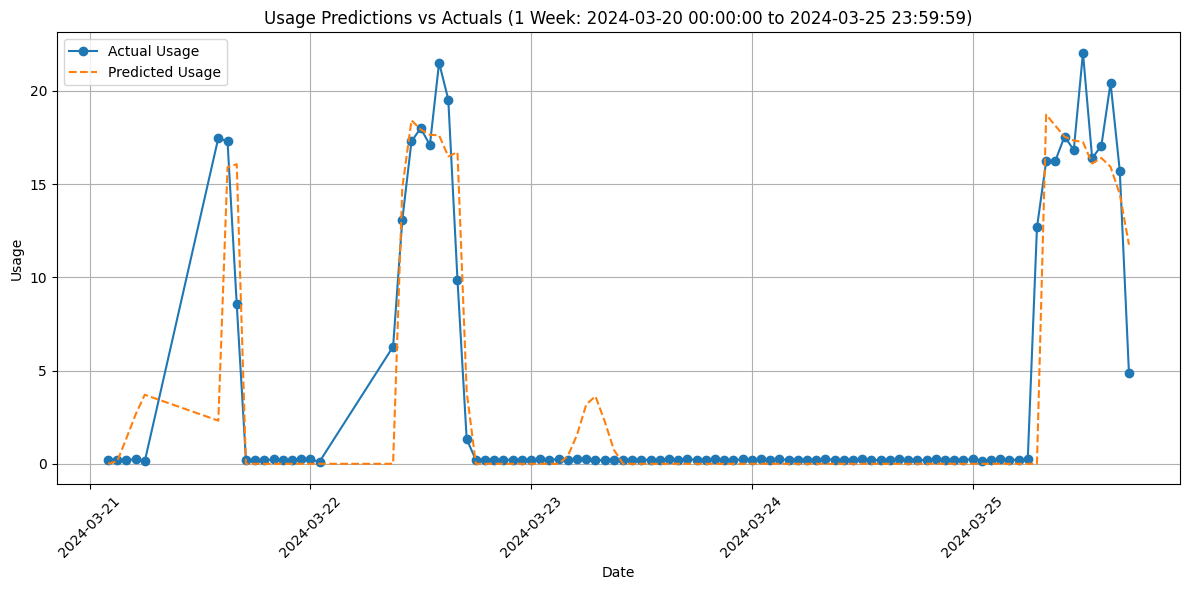

In [32]:
plt.figure(figsize=(12, 6))

plt.plot(week_data.index[sequence_length:], y_week, label='Actual Usage', marker='o')
plt.plot(week_data.index[sequence_length:], predictions_week, label='Predicted Usage', linestyle='--')

# Format sumbu x agar sesuai dengan per hari
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator())

plt.title(f'Usage Predictions vs Actuals (1 Week: {start_date} to {end_date})')
plt.xlabel('Date')
plt.ylabel('Usage')
plt.legend()
plt.grid()
plt.xticks(rotation=45)  
plt.tight_layout() 
plt.show()

In [33]:
full_time_range = pd.date_range(start=df.index.min(), end=df.index.max(), freq='H')

df = df.reindex(full_time_range)

df.reset_index(inplace=True)
df.rename(columns={'index': 'timestamp'}, inplace=True)

print(f"Jumlah nilai NaN di 'usage': {df['usage'].isna().sum()}")

df.head(10)

Jumlah nilai NaN di 'usage': 553


C:\Users\62813\AppData\Local\Temp\ipykernel_27344\1763490669.py:1: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  full_time_range = pd.date_range(start=df.index.min(), end=df.index.max(), freq='H')


,timestamp,hourly average,usage,hour,year,month,week,weekday,usage_scaled
0,2024-02-01 00:00:00,1.955991e+07,0.000000,0.0,2024.0,2.0,5,3.0,0.000000
1,2024-02-01 01:00:00,1.956011e+07,0.199500,1.0,2024.0,2.0,5,3.0,0.005519
2,2024-02-01 02:00:00,1.956033e+07,0.220500,2.0,2024.0,2.0,5,3.0,0.006099
3,2024-02-01 03:00:00,1.956056e+07,0.225000,3.0,2024.0,2.0,5,3.0,0.006224
4,2024-02-01 04:00:00,1.956076e+07,0.204500,4.0,2024.0,2.0,5,3.0,0.005657
5,2024-02-01 05:00:00,1.956099e+07,0.234100,5.0,2024.0,2.0,5,3.0,0.006476
6,2024-02-01 06:00:00,1.956119e+07,0.197400,6.0,2024.0,2.0,5,3.0,0.005460
7,2024-02-01 07:00:00,1.956787e+07,6.675750,7.0,2024.0,2.0,5,3.0,0.184664
8,2024-02-01 08:00:00,1.958493e+07,17.059417,8.0,2024.0,2.0,5,3.0,0.471897
9,2024-02-01 09:00:00,1.960156e+07,16.638833,9.0,2024.0,2.0,5,3.0,0.460263


Due to missing data, such as when the IoT devices are turned off from late night until morning, the model receives incomplete sequences, which leads to incorrect predictions since the sequence length is set to 24.

There are also GCP Credit consideration as LSTM forecast results